In [12]:
from stable_baselines3 import SAC
from asv_glider_bearing_dist_env import AsvGliderBearingEnv

env = AsvGliderBearingEnv()

model = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    gamma=0.99,
    batch_size=256,
    buffer_size=100000,
    train_freq=1,
    gradient_steps=1,
)

model.learn(total_timesteps=100_000)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [11]:
# Visualize the results
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

print("Testing trained policy and recording trajectory...")

obs, info = env.reset()

asv_traj = []
glider_traj = []
rewards = []
times = []

for step in range(1000):  # one episode
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    # store
    asv_traj.append(env.asv_pos.copy())
    glider_traj.append(env.glider_pos.copy())
    rewards.append(reward)
    times.append(env.t)

    if terminated or truncated:
        print("Episode ended early at step", step)
        break

asv_traj = np.array(asv_traj)
glider_traj = np.array(glider_traj)
rewards = np.array(rewards)
times = np.array(times)

# 2D arrays: save as CSV with x,y columns
np.savetxt("asv_traj.csv", asv_traj, delimiter=",", header="x_asv,y_asv", comments="")
np.savetxt("glider_traj.csv", glider_traj, delimiter=",", header="x_glider,y_glider", comments="")

# 1D arrays: save as single-column CSV
np.savetxt("rewards.csv", rewards, delimiter=",", header="reward", comments="")
np.savetxt("times.csv", times, delimiter=",", header="t", comments="")


Testing trained policy and recording trajectory...


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


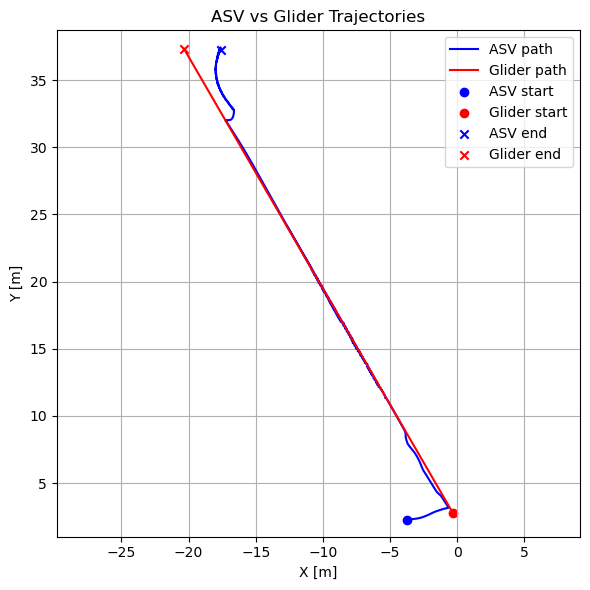

In [9]:
# 2D trajectory plot
plt.figure(figsize=(6, 6))
plt.plot(asv_traj[:, 0], asv_traj[:, 1], label="ASV path", color = 'blue')
plt.plot(glider_traj[:, 0], glider_traj[:, 1], label="Glider path", color = 'red')

plt.scatter(asv_traj[0, 0], asv_traj[0, 1], marker="o", label="ASV start", color = 'blue')
plt.scatter(glider_traj[0, 0], glider_traj[0, 1], marker="o", label="Glider start", color = 'red')
plt.scatter(asv_traj[-1, 0], asv_traj[-1, 1], marker="x", label="ASV end", color = 'blue')
plt.scatter(glider_traj[-1, 0], glider_traj[-1, 1], marker="x", label="Glider end", color = 'red')

plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("ASV vs Glider Trajectories")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()


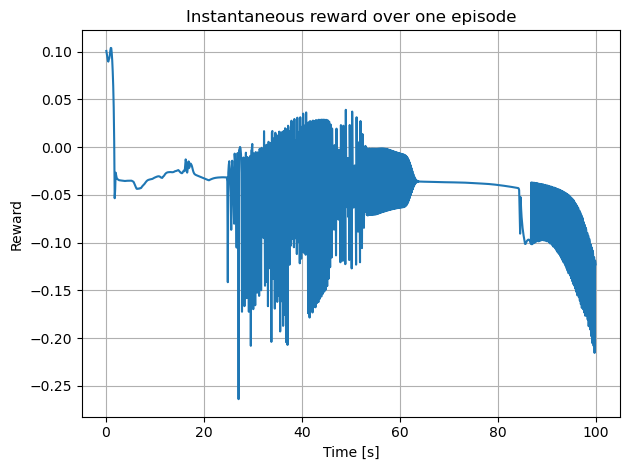

In [10]:
plt.figure()
plt.plot(times, rewards)
plt.xlabel("Time [s]")
plt.ylabel("Reward")
plt.title("Instantaneous reward over one episode")
plt.grid(True)
plt.tight_layout()
plt.show()


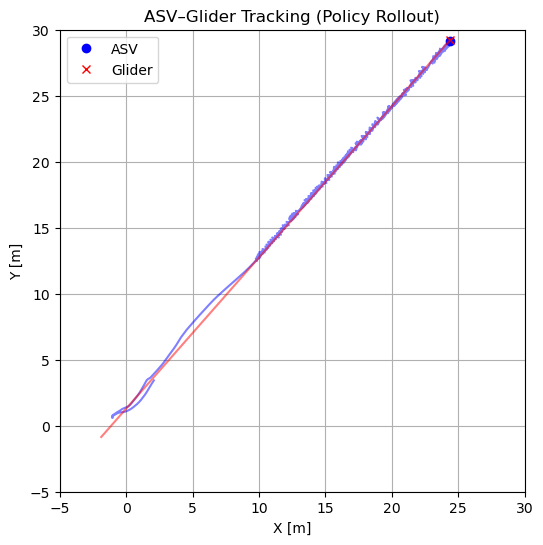

In [6]:
import matplotlib.pyplot as plt
from matplotlib import animation

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-5, 30)
ax.set_ylim(-5, 30)
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_title("ASV–Glider Tracking (Policy Rollout)")
ax.grid(True)

asv_point, = ax.plot([], [], "bo", label="ASV")
glider_point, = ax.plot([], [], "rx", label="Glider")
asv_path, = ax.plot([], [], "b-", alpha=0.5)
glider_path, = ax.plot([], [], "r-", alpha=0.5)
ax.legend()

def init():
    asv_point.set_data([], [])
    glider_point.set_data([], [])
    asv_path.set_data([], [])
    glider_path.set_data([], [])
    return asv_point, glider_point, asv_path, glider_path

def animate(i):
    asv_point.set_data(asv_traj[i, 0], asv_traj[i, 1])
    glider_point.set_data(glider_traj[i, 0], glider_traj[i, 1])
    asv_path.set_data(asv_traj[:i+1, 0], asv_traj[:i+1, 1])
    glider_path.set_data(glider_traj[:i+1, 0], glider_traj[:i+1, 1])
    return asv_point, glider_point, asv_path, glider_path

anim = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(asv_traj), interval=50, blit=True
)

#plt.show()
# Or save:
anim.save("asv_glider_tracking.mp4", fps=20, extra_args=["-vcodec", "libx264"])
